# Data Loading

In [25]:
import glob
from pathlib import Path
import pandas as pd
import cv2
import numpy as np

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Model

from matplotlib import pyplot as plt


In [26]:
# Change Location to file 
# !unzip /content/drive/MyDrive/datasets/ML_m1_1.zip

In [27]:
loc = './ML_m1'
files = glob.glob(f"{loc}/clean/*")

In [28]:
fileStems = [Path(x).stem for x in files]
print(fileStems[0])

70_129


In [29]:
full_df = pd.DataFrame(fileStems,columns=['stem'])
#Shuffle
full_df = full_df.sample(frac=1)

In [30]:
train_df = full_df[:int(0.95*len(full_df))]
test_df = full_df[int(0.95*len(full_df)):]

In [31]:
# Creating Training List 
train_stems = train_df['stem'].tolist()
train_data = []
noisy_train_data = []



for stem in train_stems:
  training_image = cv2.imread(f"{loc}/clean/{stem}.png",0)
  noisy_training_image = cv2.imread(f"{loc}/noisy/{stem}.png",0)

  train_data.append(training_image)
  noisy_train_data.append(noisy_training_image)


train_data = np.array(train_data)
noisy_train_data = np.array(noisy_train_data)

print(f'Train Data Shape : {train_data.shape}')
print(f'Noisy Train Data Shape : {noisy_train_data.shape}')

Train Data Shape : (190, 400, 400)
Noisy Train Data Shape : (190, 400, 400)


In [32]:
# Creating Testing List 
test_stems = test_df['stem'].tolist()
test_data = []
noisy_test_data = []



for stem in test_stems:
  testing_image = cv2.imread(f"{loc}/clean/{stem}.png",0)
  noisy_testing_image = cv2.imread(f"{loc}/noisy/{stem}.png",0)

  test_data.append(training_image)
  noisy_test_data.append(noisy_training_image)

test_data = np.array(test_data)
noisy_test_data = np.array(noisy_test_data)



print(f'Test Data Shape : {test_data.shape}')
print(f'Noisy Test Data Shape : {noisy_test_data.shape}')


Test Data Shape : (10, 400, 400)
Noisy Test Data Shape : (10, 400, 400)


In [33]:
# Utility Functions

def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 400, 400, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(400, 400))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(400, 400))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [34]:
# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)


noisy_train_data = preprocess(noisy_train_data)
noisy_test_data = preprocess(noisy_test_data)


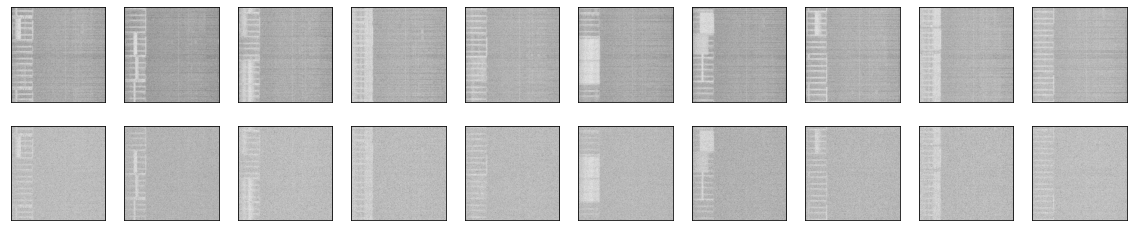

In [35]:
display(train_data, noisy_train_data)

# Model

In [36]:
input = layers.Input(shape=(400, 400, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400, 400, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 400, 400, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 200, 200, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 200, 200, 32)     9248

In [45]:
# Self Autoencoding 

autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=200,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/200
2/2 [==============================] - 1s 190ms/step - loss: 0.5690 - val_loss: 0.5708
Epoch 2/200
2/2 [==============================] - 0s 154ms/step - loss: 0.5688 - val_loss: 0.5695
Epoch 3/200
2/2 [==============================] - 0s 154ms/step - loss: 0.5685 - val_loss: 0.5681
Epoch 4/200
2/2 [==============================] - 0s 157ms/step - loss: 0.5674 - val_loss: 0.5691
Epoch 5/200
2/2 [==============================] - 0s 158ms/step - loss: 0.5678 - val_loss: 0.5684
Epoch 6/200
2/2 [==============================] - 0s 158ms/step - loss: 0.5675 - val_loss: 0.5682
Epoch 7/200
2/2 [==============================] - 0s 154ms/step - loss: 0.5672 - val_loss: 0.5686
Epoch 8/200
2/2 [==============================] - 0s 152ms/step - loss: 0.5675 - val_loss: 0.5681
Epoch 9/200
2/2 [==============================] - 0s 153ms/step - loss: 0.5671 - val_loss: 0.5684
Epoch 10/200
2/2 [==============================] - 0s 158ms/step - loss: 0.5673 - val_loss: 0.5680
Epoch 11/

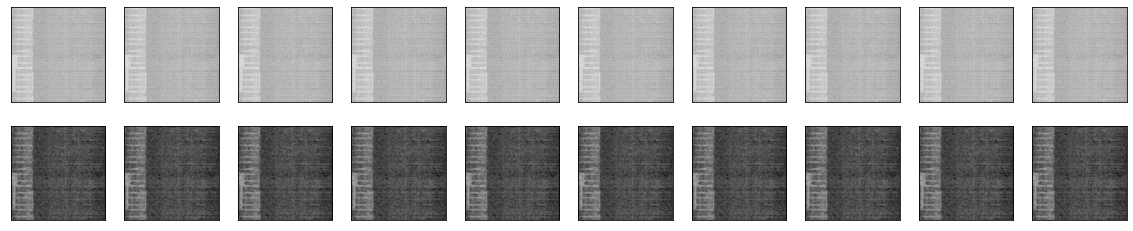

In [46]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [47]:
# Noise Autoencoding 
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=150,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/150
2/2 [==============================] - 0s 186ms/step - loss: 0.5684 - val_loss: 0.5699
Epoch 2/150
2/2 [==============================] - 0s 155ms/step - loss: 0.5682 - val_loss: 0.5691
Epoch 3/150
2/2 [==============================] - 0s 156ms/step - loss: 0.5681 - val_loss: 0.5682
Epoch 4/150
2/2 [==============================] - 0s 155ms/step - loss: 0.5675 - val_loss: 0.5686
Epoch 5/150
2/2 [==============================] - 0s 154ms/step - loss: 0.5674 - val_loss: 0.5687
Epoch 6/150
2/2 [==============================] - 0s 154ms/step - loss: 0.5676 - val_loss: 0.5682
Epoch 7/150
2/2 [==============================] - 0s 154ms/step - loss: 0.5673 - val_loss: 0.5685
Epoch 8/150
2/2 [==============================] - 0s 153ms/step - loss: 0.5673 - val_loss: 0.5684
Epoch 9/150
2/2 [==============================] - 0s 156ms/step - loss: 0.5674 - val_loss: 0.5682
Epoch 10/150
2/2 [==============================] - 0s 157ms/step - loss: 0.5673 - val_loss: 0.5684
Epoch 11/

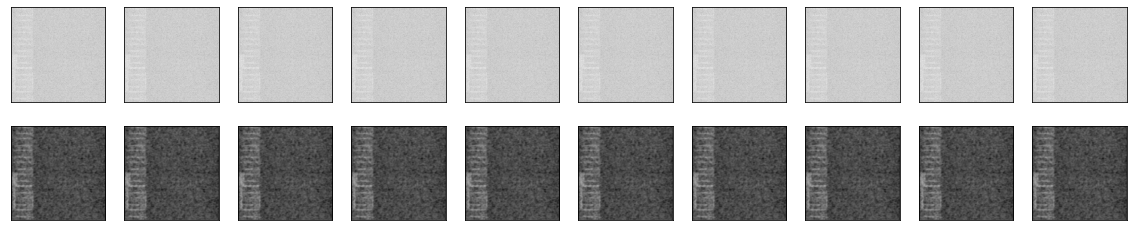

In [48]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Model Prediction')

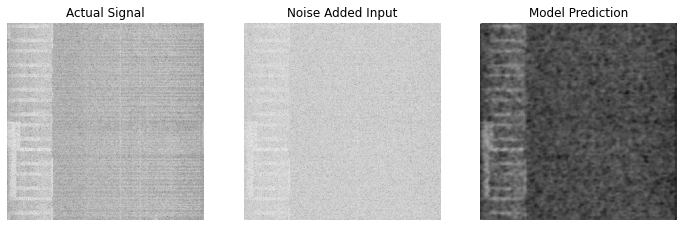

In [49]:
samplePos = 0 
fig = plt.figure(figsize=(12, 10))


rows = 1
columns = 3
fig.add_subplot(rows, columns, 1)

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
plt.imshow(test_data[samplePos].reshape(400,400))
plt.axis('off')
plt.title("Actual Signal")

fig.add_subplot(rows, columns, 2)
plt.imshow(noisy_test_data[samplePos].reshape(400,400))
plt.axis('off')
plt.title("Noise Added Input")
  
fig.add_subplot(rows, columns, 3)
plt.imshow(predictions[samplePos].reshape(400,400))
plt.axis('off')
plt.title("Model Prediction")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Model Prediction')

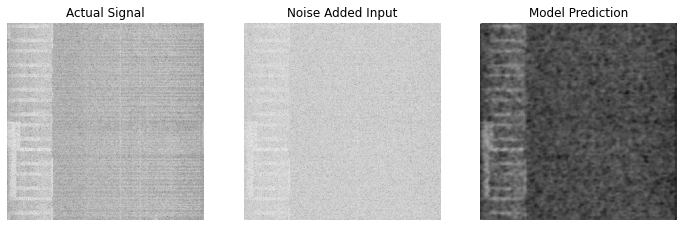

In [50]:
samplePos = 1
fig = plt.figure(figsize=(12, 10))


rows = 1
columns = 3
fig.add_subplot(rows, columns, 1)

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
plt.imshow(test_data[samplePos].reshape(400,400))
plt.axis('off')
plt.title("Actual Signal")

fig.add_subplot(rows, columns, 2)
plt.imshow(noisy_test_data[samplePos].reshape(400,400))
plt.axis('off')
plt.title("Noise Added Input")
  
fig.add_subplot(rows, columns, 3)
plt.imshow(predictions[samplePos].reshape(400,400))
plt.axis('off')
plt.title("Model Prediction")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Model Prediction')

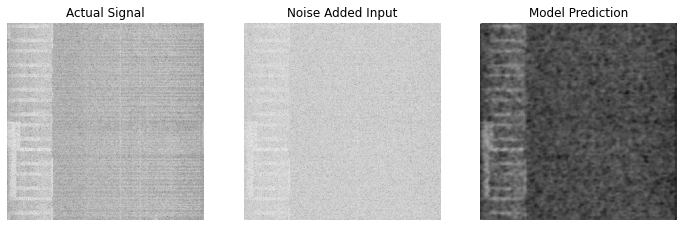

In [51]:
samplePos = 2
fig = plt.figure(figsize=(12, 10))


rows = 1
columns = 3
fig.add_subplot(rows, columns, 1)

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
plt.imshow(test_data[samplePos].reshape(400,400))
plt.axis('off')
plt.title("Actual Signal")

fig.add_subplot(rows, columns, 2)
plt.imshow(noisy_test_data[samplePos].reshape(400,400))
plt.axis('off')
plt.title("Noise Added Input")
  
fig.add_subplot(rows, columns, 3)
plt.imshow(predictions[samplePos].reshape(400,400))
plt.axis('off')
plt.title("Model Prediction")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Model Prediction')

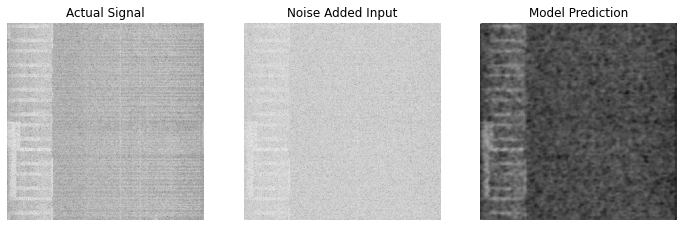

In [52]:
samplePos = 3
fig = plt.figure(figsize=(12, 10))


rows = 1
columns = 3
fig.add_subplot(rows, columns, 1)

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
plt.imshow(test_data[samplePos].reshape(400,400))
plt.axis('off')
plt.title("Actual Signal")

fig.add_subplot(rows, columns, 2)
plt.imshow(noisy_test_data[samplePos].reshape(400,400))
plt.axis('off')
plt.title("Noise Added Input")
  
fig.add_subplot(rows, columns, 3)
plt.imshow(predictions[samplePos].reshape(400,400))
plt.axis('off')
plt.title("Model Prediction")

__Ref__ : [Keras AutoEncoder](https://keras.io/examples/vision/autoencoder/)